# Test

In [2]:
import os
import sys

import random

import numpy as np 
import matplotlib.pyplot as plt

from pydub import AudioSegment
from pydub.utils import mediainfo

from IPython.display import Audio, display

from scipy.signal import spectrogram

import pandas as pd

import librosa

In [44]:
# TODO to config file

DATA_FOLDER = os.path.join(os.path.dirname("__file__"), '..', 'data')
RAW_DATA_FOLDER = os.path.join(DATA_FOLDER, 'raw')
PREPROCESSED_DATA_FOLDER = os.path.join(DATA_FOLDER, 'preprocessed')

In [34]:
os.path.normpath(os.path.join(os.path.dirname('..\\data\\raw\\train_audio\\vesspa\\XC147505.mp3'), '..', '..', '..', 'preprocessed'))

'..\\data\\preprocessed'

In [54]:
class BirdAudio:
    def __init__(self, filepath):
        self.filepath = filepath
        self.segment = AudioSegment.from_file(self.filepath, format="mp3").split_to_mono()[0]
        self.array = None

    def load(self):
        return librosa.load(self.filepath, sr=None, mono=False)
    
    def get_array(self):
        '''Get raw data as np.array from audio segment'''
        self.array = np.asarray(self.segment.get_array_of_samples())
        return self.array
    
    def convert_to_wav(self):
        output_filepath = os.path.join(PREPROCESSED_DATA_FOLDER, 'train_audio', '')
        AudioSegment.export(self.segment, output_filepath, format='wav')
        return 

    def compute_spectrogram(self):
        if self.array is None:
            self.get_array()
        f, t, Sxx = spectrogram(self.array, fs=self.segment.frame_rate)
        return t, f, 10*np.log(Sxx + 1e-10)
    
    def display(self):
        if self.array is None:
            self.get_array()
        fig, axes = plt.subplots(2, 1, figsize=(15,5))
        axes[0].plot(self.array)
        axes[1].pcolormesh(*self.compute_spectrogram(), shading='gouraud', cmap='Greys')

    


class BirdAudioDataset:

    def __init__(self, reset=False):
        '''BirdAudioDataset constructor'''

        self.filepath = os.path.join(DATA_FOLDER, 'metadata', 'train_preproc.csv')
        if os.path.exists(self.filepath) and not reset:
            self.df = pd.read_csv(self.filepath, index_col=0)
        else:
            self.df = self.preprocess_train_csv()
            self.df.to_csv(self.filepath)

    def preprocess_train_csv(self):
        '''Load raw train.csv, select features and add audio filepath feature'''

        train_csv = os.path.join(DATA_FOLDER, 'metadata', 'train.csv')
        df = pd.read_csv(train_csv)
        features = ['ebird_code', 'duration', 'sampling_rate', 'channels', 'rating', 'longitude', 'latitude', 'date', 'time', 'url', 'filename']
        df = df[features]

        def get_audiopath(row):
            return os.path.join(RAW_DATA_FOLDER, 'train_audio', row['ebird_code'], row['filename'])

        df['audiopath'] = df.apply(get_audiopath, axis=1)
        
        return df

    def get_audio(self, id: int):
        audio_info = self.df.iloc[[id]]
        display(audio_info)
        display(Audio(audio_info.iloc[0]['audiopath']))
        return BirdAudio(audio_info.iloc[0]['audiopath'])
        


,ebird_code,duration,sampling_rate,channels,rating,longitude,latitude,date,time,url,filename,audiopath
15252,plsvir,64,44100 (Hz),1 (mono),4.5,-107.8318,27.5288,2013-08-12,08:42,https://www.xeno-canto.org/338007,XC338007.mp3,..\data\raw\train_audio\plsvir\XC338007.mp3


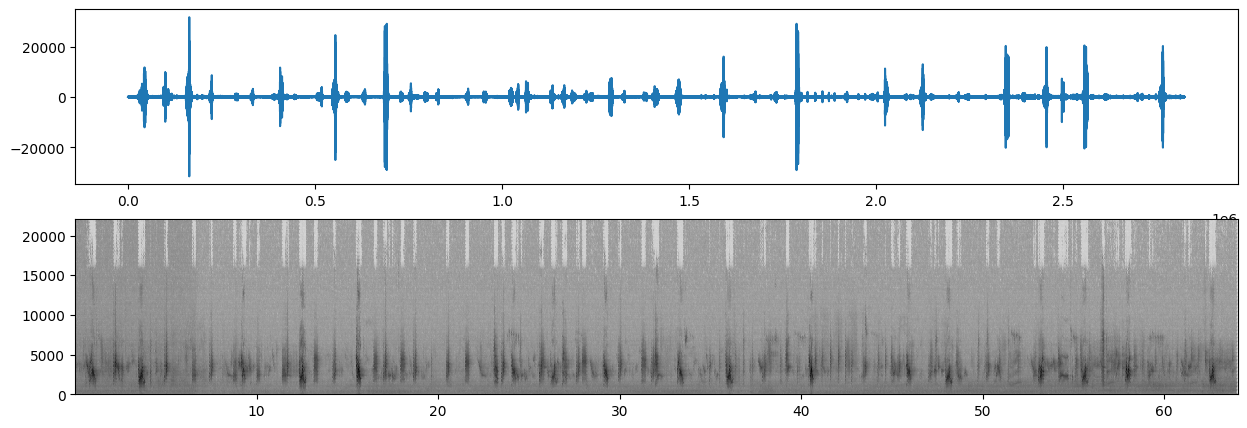

In [55]:
bird_audio_dataset = BirdAudioDataset(reset=True)

random_id = random.randint(0, bird_audio_dataset.df.shape[0] - 1)
bird_audio = bird_audio_dataset.get_audio(random_id)
bird_audio.display()